# TP1 Análisis exploratorio de datos
## Canciones de Spotify
El dataset que elegimos contiene información sobre una amplia variedad de pistas de música subidas en Spotify, abarcando distintos géneros. Cada fila del dataset representa una canción individual y está identificada de manera única mediante un ID. Además, se incluyen detalles relevantes como el nombre de la pista, el género musical, los artistas que la interpretan, el álbum al que pertenece, y si la canción contiene contenido explícito. Por último se proporciona un puntaje de popularidad, que varía de 0 a 100, reflejando la aceptación y difusión de la canción en la plataforma, y éste último va a ser nuestro objetivo principal a la hora de predecir.

### 1. Listado de variables y selección

- id: Identificador único para la canción de Spotify.
- name: Nombre de la canción.
- genre: Género de la canción.
- artists: Nombres de los artistas que compusieron la canción, separados por comas si hay multiples artistas.
- album: Nombre del album al que pertence la canción.
- popularity: [VAR DE SALIDA] Puntaje de popularidad de la canción (0-100, más alto es más popular).
- duration_ms: Duración de la canción en milisegundos.
- explicit: Booleano indicando si la canción contiene contenido explícito.


**Variables de entrada:**
- genre
- artists
- duration_ms
- explicit


**Variable de salida:** popularity

**Variables que no se utilizarán:**
- id: Esta variable será ignorada ya que es simplemente un identificador único y no tiene relación directa con la popularidad de la canción.

- name y album: Utilizar estas variables implicaría transformar texto a una representación numérica, lo que podría resultar en un alto número de columnas si se utiliza un enfoque como One Hot Encoding. Dado que estas variables no tienen una relación clara con la popularidad (a menos que se quiera explorar una posible correlación con ciertos nombres de canciones o álbumes específicos, lo cual parece menos relevante), es razonable no utilizarlas.

en ambos casos, no aportan información directa o útil para predecir la popularidad, y su inclusión podría complicar innecesariamente el modelo sin beneficios claros.

### 2. Análisis detallado de un conjunto de variables

Distribución de la Variable de Salida (popularity)

**Descripción:**

popularity es la variable objetivo. Es una variable numérica discreta, representada en una escala de 0 a 100, que mide la popularidad de una canción en Spotify.

**Análisis:**

**Preguntas para el proveedor de los datos**
- ¿Cómo se determinó la popularidad de las canciones?
- ¿Existen géneros musicales que no están representados en el dataset?
- ¿Hay algún sesgo en los datos (por ejemplo, más canciones de ciertos géneros)?

**Preprocesado:**
- genre: One Hot Encoder. 
- artists: Count Vectorizer y luego un PCA para reducir la dimensionalidad
- duration_ms y popularity: StandardScale

**Limpieza:**
- Eliminar datos con la columna de "duration_ms" menores a 1 minuto y mayores a 10 (considerados como outliers)
- El dataset no presenta datos nulls

### Análisis
- duration_ms: no hay canciones muy populares que duren menos de 150000ms o más de 250000ms
- explicit: tiene una distribución similar de popularidad, cabe destacar que las canciones explicitas ganan por muy poca diferencia, sin embargo hay outliers en canciones no explicitas que poseen una muy alta popularidad.
- genre: la mayoría en si se encuentran concentrados en un cierto rango de popularidad, sin embargo la mayoría tienen outliers de casos de éxitos como también de fracasos. pocos casos como el genero "ska" estan equilibradamente distribuidos sin tener una concentración clara en un cierto rango de popularidad.


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd 
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn_pandas import DataFrameMapper
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics

df = pd.read_csv('spotify_tracks.csv')

In [2]:
df = df.drop(columns=['id', 'album'])
df = df[(df['duration_ms'] < 600000) & (df['duration_ms'] > 10000)] #probamos filtrar las canciones que duran más de 10 minutos

In [3]:
def evaluate_model(model, set_names=('train', 'validation'), title='', show_cm=False):
    if title:
        display(title)
        
    final_metrics = {
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1': [],        
    }
        
    for i, set_name in enumerate(set_names):
        assert set_name in ['train', 'validation', 'test']
        set_data = globals()[set_name]  # <- hack feo...

        y = set_data.popularity_category
        y_pred = model.predict(set_data)
        final_metrics['Accuracy'].append(metrics.accuracy_score(y, y_pred))
        final_metrics['Precision'].append(metrics.precision_score(y, y_pred, average='macro'))
        final_metrics['Recall'].append(metrics.recall_score(y, y_pred, average='macro'))
        final_metrics['F1'].append(metrics.f1_score(y, y_pred, average='macro'))
        
        if show_cm:
            cm = metrics.confusion_matrix(y, y_pred)
            cm_plot = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
            cm_plot.plot(cmap="Blues")
            cm_plot.ax_.set_title(set_name)
        
    display(pd.DataFrame(final_metrics, index=set_names))

'Knn'

,Accuracy,Precision,Recall,F1
train,0.898936,0.775422,0.675969,0.717126
validation,0.820574,0.508438,0.466770,0.479136


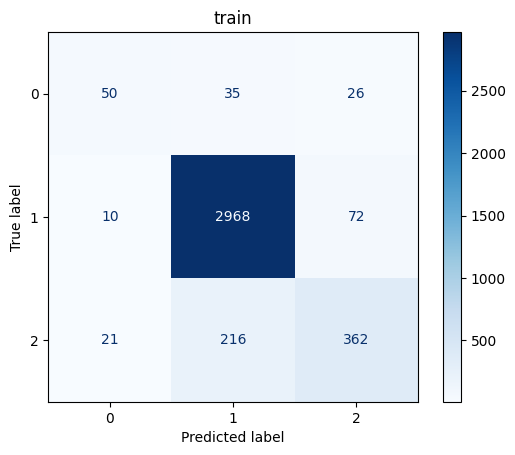

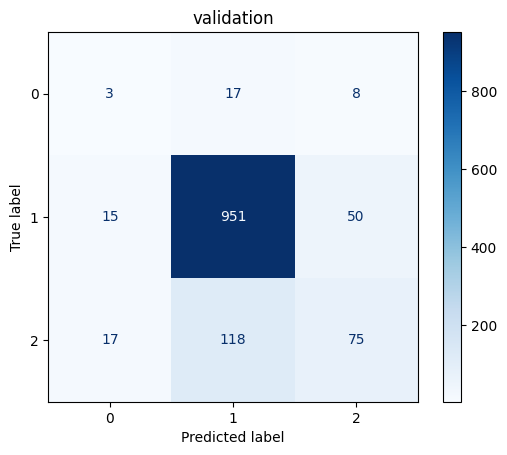

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

def categorize_popularity(popularity):
    if 0 <= popularity <= 50:
        return 'baja'
    elif 50 < popularity <= 70:
        return 'media'
    else:
        return 'alta'

def categorize_duration(duration):
    if 0 < duration <= 60000:
        return 'rango-0'
    elif 60000 <= duration < 120000:
        return 'rango-1'
    elif 120000 <= duration < 180000:
        return 'rango-2'
    elif 180000 <= duration < 240000:
        return 'rango-3'
    elif 240000 <= duration < 300000:
        return 'rango-4'
    elif 300000 <= duration < 360000:
        return 'rango-5'
    elif 360000 <= duration < 420000:
        return 'rango-6'
    elif 420000 <= duration < 480000:
        return 'rango-7'
    elif 480000 <= duration < 540000:
        return 'rango-8'
    else:
        return 'rango-9'

df['popularity_category'] = df['popularity'].apply(categorize_popularity)

df['duration_category'] = df['duration_ms'].apply(categorize_duration)

df['genre_avg_popularity'] = df.groupby('genre')['popularity'].transform('mean')

# 60% train, 20% test, 20% validation
train, not_train = train_test_split(df, test_size=0.4, random_state=42)
validation, test = train_test_split(not_train, test_size=0.5, random_state=42)

train.shape, validation.shape, test.shape

mapper = DataFrameMapper([
    (['genre'], OneHotEncoder()),
    ('name', Pipeline([
        ('vectorizer', CountVectorizer()),
        ('pca', PCA(n_components=50))
        # ('pca', PCA(n_components=0.95)) no funciona
    ])),
    ('artists', Pipeline([
        ('vectorizer', CountVectorizer()),
        ('pca', PCA(n_components=50))
        # ('pca', PCA(n_components=0.95)) no funciona
    ])),
    (['duration_ms'], StandardScaler()),
    ('explicit', None),
    (['duration_category'], OneHotEncoder()),
    (['genre_avg_popularity'], StandardScaler()),
], df_out=True)

mapper.fit_transform(df)

K = 3

knn_model = Pipeline([
    ('mapper', mapper),
    ('classifier', KNeighborsClassifier(n_neighbors=K)),
])

# knn_model.fit(train, train.popularity_category)

knn_model.fit(train, train['popularity_category'])

evaluate_model(knn_model, title='Knn', show_cm=True)

In [17]:
tree_model = Pipeline([
    ('mapper', mapper),
    ('classifier', DecisionTreeClassifier(max_depth=8, random_state=42)),
])

tree_model.fit(train, train['popularity_category'])


evaluate_model(tree_model, title='Decision Tree')

'Decision Tree'

,Accuracy,Precision,Recall,F1
train,0.909574,0.872372,0.690415,0.753425
validation,0.844498,0.556739,0.507077,0.524100


In [6]:
from sklearn.ensemble import RandomForestClassifier

forest_model_limits = RandomForestClassifier(n_estimators=100, max_depth=8, max_features=5, random_state=42)

rf_model_limits = Pipeline([
    ('mapper', mapper),
    ('classifier', forest_model_limits),
])

rf_model_limits.fit(train, train['popularity_category'])

evaluate_model(rf_model_limits, title='Random Forest with limits')

'Random Forest with limits'

,Accuracy,Precision,Recall,F1
train,0.844947,0.943636,0.440704,0.488534
validation,0.817384,0.534705,0.350137,0.332516


In [7]:
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(knn_model, df, df['popularity_category'], cv=kf, scoring='accuracy')

print(f'Accuracy en cada fold: {scores}')
print(f'Accuracy promedio: {scores.mean()}')

Accuracy en cada fold: [0.84529506 0.81100478 0.83811802 0.8292099  0.80047885]
Accuracy promedio: 0.8248213219692196


In [18]:
df.sample(5)

,name,genre,artists,popularity,duration_ms,explicit,popularity_category,duration_category,genre_avg_popularity
5530,Sleep,sleep,NAV,35,186000,True,baja,rango-3,53.979592
4872,Reggaeton Latino - Chosen Few Remix (feat. Fat...,reggaeton,"Boy Wonder CF, Don Omar, Fat Joe, N.O.R.E., L....",40,291386,False,baja,rango-4,41.918367
2502,Legend,hardstyle,Tevvez,60,189679,False,media,rango-3,36.300000
3352,K-POP,k-pop,"Travis Scott, Bad Bunny, The Weeknd",45,185220,False,baja,rango-3,28.600000
2253,Grunge,grunge,Submarine,11,311710,False,baja,rango-5,28.265306
